<table align="left">
  <td>
    <a href="https://tinyurl.com/2gd2b9md" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Transfer Learning con TensorFlow

## Parte 1. Extracción de características

En este notebook vamos a ver cómo podemos usar transfer learning para mejorar el rendimiento de un modelo de clasificación de imágenes.

**Transfer learning** es una técnica de aprendizaje automático que nos permite aprovechar los patrones aprendidos por un modelo en un problema para resolver otro problema.

<img src="https://tinyurl.com/2fdf3whn" width="600"/>

Hay dos beneficios principales al usar transfer learning:

- Puede aprovechar una arquitectura de red neuronal existente probada para funcionar en problemas similares a los nuestros.
- Puede aprovechar una arquitectura de red neuronal que ya funciona y que ha aprendido patrones en datos similares a los nuestros. Esto a menudo resulta en lograr excelentes resultados con menos datos personalizados.

:book: **Vamos a ver lo siguiente con TensorFlow:**

- Introdución a transfer learning (una forma de superar todos nuestros modelos anteriores)
- Usar un dataset más pequeño para experimentar más rápido (10% de las muestras de entrenamiento de 10 clases de comida)
- Construir un modelo de extracción de características de transfer learning usando TensorFlow Hub
- Introducir el callback TensorBoard para rastrear los resultados del entrenamiento del modelo
- Comparar los resultados del modelo usando TensorBoard

### 1. Cargar los datos

Se utilizará el 10% de las muestras de entrenamiento de 10 clases de comida de Food101. 

In [9]:
# Get data (10% of labels)
import zipfile
import os
if(os.path.exists('10_food_classes_10_percent')):
    print('Files exists')
else:
    # Download data
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

    # Unzip the downloaded file
    zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
    zip_ref.extractall()
    zip_ref.close()
    print("Dataset is ready")

Files exists


In [6]:
# Verificar el contenido de la carpeta
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test

In [7]:
# directorios de entrenamiento y test
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [17]:
# Obtener las clases de los directorios
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [20]:
# ImageDataGenerator para entrenamiento y test
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Cargar datos de entrenamiento y test
print('training data...')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        seed=42)
print('test data...')
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        seed=42)

training data...
Found 750 images belonging to 10 classes.
test data...
Found 2500 images belonging to 10 classes.


> :key: **Nota:** En este notebook, usaremos el 10% de las muestras de entrenamiento de 10 clases de comida de Food101, para ver como funciona el transfer learning con un conjunto de datos más pequeño.

Image shape: (512, 512, 3)


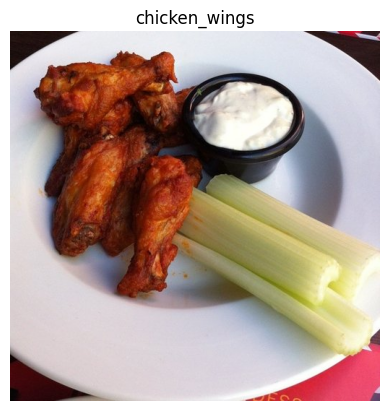

In [16]:
import helper_functions as hf
import random

img = hf.view_random_image(target_dir=train_dir,target_class=random.choice(class_names))

## 2. Configuración de Callbacks

Callbacks son funciones que se pueden pasar a un modelo de TensorFlow durante el entrenamiento para realizar una acción en un punto específico del entrenamiento. Algunos de los callbacks más comunes son:

- `tf.keras.callbacks.ModelCheckpoint` - Guarda el modelo en un intervalo específico.
- `tf.keras.callbacks.EarlyStopping` - Detiene el entrenamiento cuando una métrica deja de mejorar.
- `tf.keras.callbacks.TensorBoard` - Guarda los registros de entrenamiento para visualizarlos en TensorBoard.

In [21]:
# Create TensorBoard callback (functionized)
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instace to store TensorBoard logs.
    Saves logs with the file name: dir_name/experiment_name/current_datetime/
    Inputs:
        dir_name (str): Directory name to save TensorBoard log files.
        experiment_name (str): Experiment name.
    Returns:
        TensorBoard callback.
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.Tensorboard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## 3. Crear un modelo utilizando TensorFlow Hub

[TensorFlow Hub](https://www.tensorflow.org/hub) es una biblioteca y plataforma para la reutilización de módulos de aprendizaje profundo.

Es posible acceder a los modelos de TensorFlow Hub en https://tfhub.dev. 

:key: **Nota:** Para identificar los modelos que presentan mejor desempeño, se puede utilizar la pagina https://paperwithcode.com. 

- https://paperswithcode.com/task/image-classification

Buscando dentro de la pagina, se puede encontrar el modelo **EfficientNet** que es un modelo de **extracción de características** de transfer learning que se puede usar para resolver problemas de clasificación de imágenes.

- **EfficientNet-B0**: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
##